Installation
--

In [ ]:
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install tensorflow==2.3.0

# !pip install tensorflow
# !pip install stable-baselines3 pyglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 949 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 39 kB/s 
     |████████████████████████████████| 2.9 MB 66.8 MB/s 
     |████████████████████████████████| 459 kB 93.1 MB/s 
     |████████████████████████████████| 20.1 MB 57.1 MB/s 
     |████████████████████████████████| 26.1 MB 12.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0


Import
--

In [ ]:
import sys
import gym
import math
import time
import pylab
import cmath
import random
import itertools
import threading
import tensorflow
import scipy as sp
import numpy as np
import pandas as pd
from gym import Env
import scipy.io as sc
import tensorflow as tf
from sys import version
from absl import logging
from numpy import ndarray
from scipy import special
from gym.utils import seeding
from scipy.constants import *
from rl.agents import DQNAgent
from scipy.special import erfinv
from scipy.integrate import quad
from scipy.linalg import toeplitz
from numba import jit, njit, prange
from gym.spaces import Discrete, Box
from collections import deque, Counter
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from mpl_toolkits.mplot3d import Axes3D
from gym import Env, error, spaces, utils
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input

# Set of times noew roman font.
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

dtype = np.float32

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
##############################################################################

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/tensor_util.py:107: DeprecationWarning: `np.object` is a deprecated ali

Multi-cell Massive MIMO env
--

In [ ]:
class M_MIMOEnv(Env):
  def __init__(self, N, M, K):
##########################################################################################################################################################################################################################################
# start : multi-cell massive MIMO envrionment 

    self.N = N              # number of cells is equals to number of BSs
    self.M = M              # number of BS transmission antnneas
    self.K = K              # number of UEs in a cell
    self.BW = 10e6          # Bandwidth = 10MHz
    self.NF = 7             # Power of noise figure [dBm]
    self.Ns = 10            # Number of sample
    self.min_p = -20        # Minimum transmission power [dBm]
    self.max_p = 23         # Maximum transmission power [dBm]
    self.num_p = 10         # Number of action space

    # get multi-cell massive MIMO channel matrix (slow generating w/ shadowing, fading)
    self.H, self.H_gain = self.get_channel_local_scatter(no_realization = self.Ns)

    # get ZF precoding vector without antenna selection
    self.precoding = self.antenna_selection(self.H, ant_sel = False)

    # get random seed
    self.seed()

    # initialize step counter
    self.count = 0
    
    # initialize state 
    self.state = None
    self.downlink_rate = None
    self.rate_list = []

    self.action_values = self.get_power_set()
    self.num_actions = len(self.action_values)
    self.action_space = spaces.Discrete(self.num_actions)
    self.action_length = self.num_actions

    # observation consists of the transmission power, SINR, and average sum-rate
    lower_bound = np.array([self.min_p, -(np.finfo(np.float32).max), -(np.finfo(np.float32).max)], dtype=np.float32)
    higher_bound = np.array([self.max_p, np.finfo(np.float32).max, np.finfo(np.float32).max], dtype=np.float32)

    self.observation_space = spaces.Box(lower_bound, higher_bound, dtype = np.float32)



##########################################################################################################################################################################################################################################
# start : multi-cell massive MIMO downlink scenario

  # generate dBm 
  def get_power_set(self):
    power_set = np.hstack([np.zeros((1), dtype=dtype), 1e-3*pow(10., np.linspace(self.min_p, self.max_p, self.num_p-1)/10.)])
    return power_set

  # generate random seed
  def randn2(self, *args, **kargs):
    args_r = tuple(reversed(args))
    uniform = np.random.rand(*args_r)
    untiform = uniform.transpose()
    
    return np.sqrt(2) * erfinv(2 * uniform - 1)
  
  # generate hermitian matrix
  def hermitian(self, X):
    return X.conj().swapaxes(-1, -2)
  # Divide function by using hermitian.
  def mldivide(self, A: ndarray, B: ndarray, A_is_hermitian=False):
    if A_is_hermitian:
        return self.hermitian(np.linalg.solve(A, self.hermitian(B)))
    else:
        return self.hermitian(np.linalg.solve(self.hermitian(A), self.hermitian(B)))


  # correlation in term of real. signal parts.
  @njit
  def correlation_real(self, x, antenna_spacing, col): 
    return np.cos(2 * np.pi * antenna_spacing * col * np.sin(x))


  # correlation in term of imag. signal parts.
  @njit
  def correlation_imag(self, x, antenna_spacing, col): 
    return np.sin(2 * np.pi * antenna_spacing * col * np.sin(x))


  # probability density function (PDF) : gussian
  @njit
  def gaussian_pdf(self, x, mean, dev): 
    return np.exp(-(x-mean) ** 2 / (2 * dev ** 2)) / (np.sqrt(2 * np.pi) * dev)


  # correlation function
  @njit
  def corr(self, x, theta, asd, antenna_spacing, dist, col, real_imag):
    if real_imag == 0:
        res = np.cos(2 * np.pi * antenna_spacing * col * np.sin(x))
    else:
        res = np.sin(2 * np.pi * antenna_spacing * col * np.sin(x))
    if dist =='gaussian':
        res *= self.gaussian_pdf(x, theta, asd)
    return res


  # Convert dBm to watts
  def dBm2Watts(self, P):
    # 1e-3* pow(10., self.n_power/10.)
    # P[w] = 10 ^ ((P[dBm] - 30) / 10);
    # P_watts = 1e-3 * pow(10., P/10.)
    P_watts = (10 ** ((P - 30) / 10))
    return P_watts


  # local scattering channel model. where the local is a single cell in total cell
  def R_local_scattering(self, M, theta, asd_deg, antenna_spacing=0.5, dist='Gaussian', accuracy=1, dtype=np.complex128):

    # In radians
    asd = asd_deg * np.pi / 180

    # correlation matrix is Toeplitz structure, so only need first row
    first_row = np.zeros([M,], dtype=dtype)

    if accuracy == 1:
        lb = None
        ub = None

        dist = dist.lower()
        if dist == 'gaussian':
            lb = theta - 20 * asd
            ub = theta + 20 * asd

        else:
            raise NotImplementedError

        for col in range(0, M):
            # distance from the first antenna
            c_real:float = quad(func=self.corr, a=lb, b=ub, args=(theta, asd, antenna_spacing, dist, col, 0))[0]
            c_imag:float = quad( func=self.corr, a=lb, b=ub, args=(theta, asd, antenna_spacing, dist, col, 1))[0]

            first_row[col] = complex(c_real, c_imag)
    elif accuracy == 2:
        # Gaussian distribution
        distance = np.arange(M)
        x1 = np.exp(1j * 2 * np.pi * antenna_spacing * np.sin(theta) * distance)
        x2 = np.exp(-asd ** 2 / 2 * (2 * np.pi * antenna_spacing * np.cos(theta) * distance) ** 2)
        first_row = x1 * x2

    return toeplitz(c=first_row.conjugate())


  # Channel statistics between UE's at random locations and the BS.
  def channel_stat_setup(self, N, K, M, asd_degs, no_BS_per_dim=None, accuracy=2,):
    # square side, in meters
    side_length = 500

    # pathloss exp
    alpha = 3.76

    # avg. channel gain in dB at the ref. distance 1 meter. At exponent set to 3.76, at 1km it's -148.1 dB
    constant_term = -35.3

     # standard deviation of shadow fading
    sigma_sf = 10

    # minimum distance between BS and UEs
    min_UE_BS_dist = 25

    # maximum distance between BS and UEs
    max_UE_BS_dist = 300
    
    # antenna spacing # of wavelengths
    antenna_spacing = 0.5
    if no_BS_per_dim is None:
        no_BS_per_dim = np.array([np.sqrt(N), np.sqrt(N)])
    inter_bs_distance = side_length / no_BS_per_dim

    # scatter the BSs
    BS_positions = np.stack(np.meshgrid(np.arange(inter_bs_distance[0]/2, side_length, inter_bs_distance[0]),np.arange(inter_bs_distance[1]/2, side_length, inter_bs_distance[1]),indexing='ij'),axis=2).reshape([-1,2])
    
    # now all the other nine alternatives of the BS locations
    wrap_locations = np.stack(np.meshgrid(np.array([-side_length, 0, side_length]), np.array([-side_length, 0, side_length]), indexing='ij' ), axis=2).reshape([-1,2])

    # for each BS locations, there are 9 possible alternative locations including the original one. Here uses broadcasting to add (9,2) to a (num_BS, 1, 2) to get a (num_BS, 9, 2)
    BS_positions_wrapped = np.expand_dims(BS_positions, axis=1) + wrap_locations

    UEpositions = np.zeros([K, N, 2])
    perBS = np.zeros([N,], dtype=np.int32)

    # normalized spatial correlation matrices
    R = np.zeros([M, M, K, N, N, len(asd_degs)], dtype=np.complex128)

    self.channel_gain = np.zeros([K, N, N])

    for i in range(N):
        # put K UEs in the cell, uniformly. UE's not satisfying the minimum distance are replaced
        res = []
        while perBS[i] < K:
            UEremaining = K - perBS[i]
            pos = np.random.uniform(-inter_bs_distance/2, inter_bs_distance/2,size=(UEremaining, 2))
            cond = np.linalg.norm(pos, ord=2, axis=1) >= min_UE_BS_dist

            # satisfying minimum distance with respect to BS shape
            pos = pos[cond, :]
            for x in pos:
                res.append(x + BS_positions[i])
            perBS[i] += pos.shape[0]
        UEpositions[:, i, :] = np.array(res)

        # loop through all BS for cross-channels
        for j in range(N):
            # distance between all UEs in cell i to BS j, considering wrap-around.
            dist_ue_i_j = np.linalg.norm(np.expand_dims(UEpositions[:, i], axis=1) - BS_positions_wrapped[j, :, :], axis=2)
            dist_bs_j = np.min(dist_ue_i_j, axis=1)
            which_pos = np.argmin(dist_ue_i_j, axis=1)

            # average channel gain with large-scale fading mdoel in (2.3), neglecting shadow fading
            self.channel_gain[:, i, j] = constant_term - alpha * 10 * np.log10(dist_bs_j)

            # generate spatial correlation matrices for channels with local scattering model
            for k in range(K):
                vec_ue_bs = UEpositions[k, i] - BS_positions_wrapped[j, which_pos[k]]
                angle_BS_j = np.arctan2(vec_ue_bs[1], vec_ue_bs[0])
                for spr, asd_deg in enumerate(asd_degs):
                    R[:, :, k, i, j, spr] = self.R_local_scattering( M, angle_BS_j, asd_deg, antenna_spacing, accuracy=accuracy)

        # all UEs in cell i to generate shadow fading realizations
        for k in range(K):
            # see if another BS has a larger avg. channel gain to the UE than BS i
            while True:
                # generate new shadow fading realizations until all UE's in cell i has its largest avg. channel gain from BS i
                shadowing = sigma_sf * self.randn2(N)
                channel_gain_shadowing = self.channel_gain[k, i] + shadowing
                if channel_gain_shadowing[i] >= np.max(channel_gain_shadowing):
                    break
            self.channel_gain[k,i,:] = channel_gain_shadowing

    return R, self.channel_gain


  # Normalized the complex values.
  def complex_normalize(self, X, axis=-1):
    mags = np.linalg.norm(np.abs(X), axis=axis, keepdims=True)
    return X / mags


  # Generate noise figure with bandwidth (20MHz)
  def noise_dbm(self,):
    return -174 + 10 * np.log10(self.BW) + self.NF


  # generate the ZF precoded combination
  def zf_combining(self,H):
    H1 = H
    A = self.hermitian(H1) @ H1 + 1e-12 * np.eye(H1.shape[-1])
    B = H1
    res = self.mldivide(A, B, A_is_hermitian=True)
    return res


  # Generate uncorrelated Rayleigh fading channel realizations with unit variance
  def get_H_rayleigh_unit(self, M, K, N, Ns):
    randn2 = np.random.randn
    H = randn2(N, N, K, M, Ns) + 1j * randn2(N, N, K, M, Ns)
    return np.sqrt(0.5) * H


  # Get local scattering channel matrix
  def get_channel_local_scatter(self, no_realization):
    # return shape:  Ns x N x N x K x M
    if self.N > 1 and self.N < 4:
        no_BS_per_dim = np.array([1, self.N])
    else:
        no_BS_per_dim = None
    R, gain_db = self.channel_stat_setup(self.N, self.K, self.M,no_BS_per_dim=no_BS_per_dim,asd_degs=[30,], accuracy=2)
    gain_db -= self.noise_dbm()

    # shape is M x M x K x N x N x no_asd_degs
    R_gain = R[:, :, :, :, :, 0] * np.power(10, gain_db / 10.0)
    R_gain = np.ascontiguousarray(np.transpose(R_gain[:, :, :, :, :], (4,3,2,1,0)))

    # now the shape is N x N x K x M x M
    # for each user, the channel between some BS to it, what is the spatial correlation. 
    # Therefore in total there are so many numbers: K * N * N * M * M
    H = self.get_H_rayleigh_unit(self.M, self.K, self.N, self.Ns)
    H_gain = np.zeros_like(H)
    for _idx in np.ndindex(*H.shape[0:3]):
        H_gain[_idx] = sp.linalg.sqrtm(R_gain[_idx]) @ H[_idx]
        # TODO: use Cholesky factorization to replace the slow matrix square root operation.
        # However, it requires the matrix to be positive semidefinite, which should be the case but due to the numerical error is not always the case.
    res = np.ascontiguousarray(np.transpose(H_gain, (4, 0, 1, 2, 3)))
    return res, H_gain


  # setting of the ZF precoding method
  def get_precoding(self, H, method="ZF", local_cell_info=True):
    res = []
    if method == "ZF":
        algo = self.zf_combining
    if local_cell_info:
        no_cells = H.shape[1]
        for j in range(no_cells):
            res.append(algo(H[:,j,j]))
    return np.stack(res, axis=1)


  # Antenna selection and power allocation by using ZF precoding
  def antenna_selection(self, H, ant_sel=True):
    Ns, N, N, K, M = H.shape
    if ant_sel:

        antenna_sel = np.zeros((Ns, N, M), dtype=np.bool_)

        # strongest K_0 antennas
        K_0 = int(M * 0.8)
        for r in range(Ns):
            for n in range(N):
                channel_power_ant = (np.abs(H[r, n, n]) ** 2).sum(axis=-2)
                top_k = np.argsort(channel_power_ant)[0:K_0]
                antenna_sel[r, n][top_k] = True
        # or randomly
        H_n = (H.transpose(2, 3, 0, 1, 4) * antenna_sel).transpose(2, 3, 0, 1, 4)

    else:
        antenna_sel = np.ones((Ns, N, M), dtype=np.bool_)
        H_n = H
    W = self.get_precoding(H_n, method="ZF", local_cell_info=True)

    # power allocation
    # W = np.sqrt(self.config["P_DL"]) * self.complex_normalize(W)
    # return W, antenna_sel
    return W


  # Calculate the downlink user-rate [bits/s/Hz]
  def DL_rate(self, channel, precoding, power):    
    H, V = channel, precoding
    W = self.complex_normalize(V, -1)

    Interval, N, K, M = H.shape[0], H.shape[1], H.shape[3], H.shape[4]
    intercell_intf = np.zeros((N, K))
    intracell_intf = np.zeros((Interval, N, K))
    sig = np.zeros((Interval, N, K))

    for n in range(Interval):
        for l in range(N):
            H_l = H[n, l] # (N, K, M)
            for k in range(K):
                w_l = W[n, l] # (K, M)
                H_llk = H_l[l, k] # (M, ) the channel between l-th BS to user k
                p_l = np.abs(np.dot(w_l.conj(), H_llk)) ** 2
                sig[n, l, k] = p_l[k]
                intracell_intf[n, l, k] = p_l.sum() - p_l[k]
                if N > 1:
                    idx_othercell = list(range(N))
                    idx_othercell.remove(l)
                    H_intercell = H[n, idx_othercell, l:l+1, k] # (L-1, 1, M) CSI, other cells to this user k
                    w_intercell = W[n, idx_othercell] #(L-1, K, M) other cell's precoding vector
                    p_inter = np.abs(w_intercell @ (H_intercell.swapaxes(-1, -2))) ** 2
                    intercell_intf[l,k] += p_inter.sum() / Interval

    int_noise = power * intercell_intf + power * intracell_intf + 1
    self.sinr = (power * sig / int_noise)

    downlink_rate = np.log2(1+self.sinr).mean(axis=0)
    # self.downlink_rate = self.BW * np.log2(1 + self.sinr).mean(axis = 0)
    return downlink_rate

##########################################################################################################################################################################################################################################
# start : reinforcement function
  def seed(self, seed = None):
    self.np_random = seed = seeding.np_random(seed)
    return [seed]


  def step(self, action):

    # where the action as same as power 
    power = env.action_values[action]
    downlink_sum = 0
    reward = 0
    
    # x, x_dot, theta, theta_dot = self.state
    s_power, s_sinr, s_sumrate = self.state

    downlink_rate = self.DL_rate(self.H, self.precoding, power)
    
    # append for checking the previous downlink user-rate [bits/s/Hz]
    self.rate_list.append(downlink_rate)
    
    s_power = power
    s_sinr = np.mean(self.sinr)
    s_sumrate = np.mean(downlink_rate)

    self.state = (s_power, s_sinr, s_sumrate)
    reward = np.mean(downlink_rate)

    self.action_length -= 1

    self.count += 1
    if self.action_length <= 0:
      done = True
    else:
      done = False
    info = {}

    return np.array(self.state), reward, done, info, downlink_rate,
  

  def reset(self):
    # mixing the random seed and select the random transmit power
    self.seed()

    # we consider the dynamic changes the UEs location, and shadowing, fading... etc.
    # get multi-cell massive MIMO channel matrix (slow generating w/ shadowing, fading)
    self.H, self.H_gain = self.get_channel_local_scatter(no_realization = self.Ns)

    # get ZF precoding vector without antenna selection
    self.precoding = self.antenna_selection(self.H, ant_sel = False)
    
    # reset the step counter
    self.count = 0

    # allocate random value each s_power, s_sinr, s_sumrate
    self.state = np.random.uniform(low = -0.05, high = 0.05, size = (3,))

    downlink_rate = None

    self.rate_list = []
    
    self.action_length = self.num_actions
    
    # return self.state
    # return np.array(self.state, dtype = np.float32)
    return np.array(self.state)


###################################################################################################################################################################################################################################################
  # Equal Power Allocation
  def equal_PA(self,):
    # Maximum downlink transmit power per BS (mW)
    pmax = self.dBm2Watts(self.max_p)

    rhoEqual = (pmax/self.K)*np.ones((1, self.K))

    # Compute downlink power per UE in case of equal power allocation
    equal_power = np.sum(np.sqrt(rhoEqual))
    equal_rate = self.DL_rate(self.H, self.precoding, equal_power).sum() / self.N

    return equal_rate

###################################################################################################################################################################################################################################################
  # Randomly Power Allocation 
  def random_PA(self,):
    random_power = np.sum(np.random.uniform(self.dBm2Watts(self.min_p), self.dBm2Watts(self.max_p), size = self.K))

    # downlink -user rate [bits/s/Hz]
    random_rate = self.DL_rate(self.H, self.precoding, random_power).sum() / self.N

    return random_rate

###################################################################################################################################################################################################################################################
  # maximum Power Allocation
  def maximum_PA(self,):
    max_power = np.sum(self.dBm2Watts(self.max_p) * np.ones((self.K)))

    # downlink -user rate [bits/s/Hz]
    max_rate = self.DL_rate(self.H, self.precoding, max_power).sum() / self.N

    return max_rate

###################################################################################################################################################################################################################################################
  # Simplified Maximum Product Power Allocation
  def maxprob_PA(self,):
    R_list = []
    P_list = []
    SP_list = []

    for j in range(self.N):
      for i in range(self.K):
        i_maxprob_power = np.sum(self.dBm2Watts(self.max_p) * np.ones((self.M)))
        i_maxprob_rate = self.DL_rate(self.H, self.precoding, i_maxprob_power).sum() / self.N

        P_list.append(i_maxprob_power)
        R_list.append(i_maxprob_rate)

        i_rate = P_list
        i_idx = list(np.arange(len(i_rate)))
        maxprob_dict = dict(zip(i_idx,i_rate))

      # extract optimal transmission power
      op_power = max(maxprob_dict, key = maxprob_dict.get)

    SP_list.append(P_list[op_power])

    est_power = np.sum(SP_list)

    maxprob_rate = self.DL_rate(self.H, self.precoding, est_power).sum() / self.N

    return maxprob_rate


################################################################################
# WMMSE power allocation
# def WMMSE_algorithm_single(N, H, Pmax, var_noise, priorities,cell_mapping = None):
#     # start_WMMSE_time = time.time()
#     vnew = 0
#     # random initialization gives much lower performance.
#     b = np.sqrt(Pmax) *np.ones(N) # np.random.rand(N) # #
#     if cell_mapping is not None:
#         for k in range(max(cell_mapping)):
#             idxs = np.where(cell_mapping == k)
#             I_k = idxs[-1].shape[-1]
#             b[idxs] = b[idxs] / I_k
            
#     f = np.zeros(N)
#     w = np.zeros(N)
#     for i in range(N):
#         f[i] = H[i, i] * b[i] / (np.matmul(np.square(H[i, :]), np.square(b)) + var_noise)
#         w[i] = 1.0 / (1 - f[i] * b[i] * H[i, i])
#         vnew = vnew + np.log2(w[i])

#     for iter in range(100):
#         vold = vnew
#         for i in range(N):
#             btmp = priorities[i]* w[i] * f[i] * H[i, i] / (AVOID_DIV_BY_ZERO + sum(priorities * w * np.square(f) * np.square(H[:, i])))
#             b[i] = min(btmp, np.sqrt(Pmax)) + max(btmp, 0) - btmp

#         vnew = 0
#         for i in range(N):
#             f[i] = H[i, i] * b[i] / (np.matmul(np.square(H[i, :]) ,np.square(b)) + var_noise)
#             w[i] = 1.0 / (AVOID_DIV_BY_ZERO + 1 - f[i] * b[i] * H[i, i])
#             vnew = vnew + np.log2(w[i])

#         if vnew - vold <= 0.01:
#             break
        
#     p_opt = np.square(b)
#     # Make sure that per BS constraint is satisfied if cell_mapping is specified.
#     if cell_mapping is not None:
#         norm_vect = np.ones(N)
#         for k in range(max(cell_mapping)):
#             idxs = np.where(cell_mapping == k)
#             if sum(p_opt[idxs]) > Pmax:
#                 norm_vect[idxs] = sum(p_opt[idxs]) / Pmax
#         p_opt = p_opt / norm_vect
#     # end_time = time.time() - start_WMMSE_time
#     # end_statistics = [end_time, iter]
#     return p_opt, iter#, end_statistics

# def WMMSE_algorithm(H,  Pmax, noise_var, priorities = None, cell_mapping = None):
#     N = H.shape[0]
#     M = H.shape[-1]
#     if priorities is None: priorities = np.ones(N)

#     p = np.zeros((N, M))
#     iters = 0
#     for m in range(M):
#         p[:,m], iter = WMMSE_algorithm_single(N, H[:,:,m], Pmax, noise_var,priorities,  cell_mapping)
#         iters += iter

#     # Return optimum result after convergence
#     return p, iters#, end_statistics

M_MIMO env test
--
* allocate random action

In [ ]:
env = M_MIMOEnv(N = 7, M = 32, K = 10)

episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, downlink_rate = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_schur.py:140: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lwork = result[-2][0].real.astype(numpy.int)


Episode:1 Score:5.904778277916043
Episode:2 Score:3.3908218800221457
Episode:3 Score:2.729488493200886
Episode:4 Score:5.739940117667961
Episode:5 Score:5.230602729167572
Episode:6 Score:6.280369687935074
Episode:7 Score:3.780985496005178
Episode:8 Score:2.6560647640538333
Episode:9 Score:3.4189578508640337
Episode:10 Score:3.1584097652724967


Algorithm-based Power Allocation
--
* equal power allocation
* random power allocation
* maximum power allocation
* maximum product sinr-based power allocation

In [ ]:
if __name__ == '__main__':
  env = M_MIMOEnv(N = 7, M = 32, K = 10)

  equal_sum_rate = env.equal_PA()
  random_sum_rate = env.random_PA()
  max_sum_rate = env.maximum_PA()
  maxprob_sum_rate = env.maxprob_PA()

  print('[SE] :: equal {}, random {}, max {}, maxprob {}'.format(equal_sum_rate, random_sum_rate, max_sum_rate, maxprob_sum_rate))

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_schur.py:140: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lwork = result[-2][0].real.astype(numpy.int)


[SE] :: equal 32.549863944255456, random 31.5269132670662, max 34.099149361187806, maxprob 37.888718763588415


Deep Q Network (DQN)-based Power Allocation
--

In [ ]:
# =============================================================================
# DEEP Q NETWORK (DQN)
# =============================================================================

# THIS IS DQN AGENT FOR THE CUSTOM ENV.
# IT USES NEURAL NETWORK TO APPROXIMATE Q FUNCTION, AND REPLAY MEMORY & TAGET Q NETWORK
class DQNAgent:
    def __init__(self, state_size, action_size, test_mode):

        # ARE YOU LOADING A PREVIOUS TRAINED DQN MODEL?
        # self.load_model = False
        self.load_model = test_mode

        # GET SIZE OF STATE AND ACTION
        self.state_size = state_size
        self.action_size = action_size

        # THESE ARE HYPER-PARAMERTERS FOR THE DQN
        self.discount_factor = 0.1
        self.learning_rate = 1e-3
        self.epsilon_decay = 0.999
        self.train_start = 500
        self.epsilon = 0.2
        self.epsilon_min = 0.0001
        self.batch_size = 256

        # CREATE REPLAY MEMORY USING DEQUE
        self.memory = deque(maxlen=50000)

        # CREATE MAIN MODEL AND TARGET MODEL
        self.model = self.build_model()
        self.target_model = self.build_model()

        # INITIALIZE TARGET MODEL
        self.update_target_model()

        # GET TRAINED MY MODEL
        if self.load_model:
            self.model.load_weights("./M_MIMO_DQN.h5")

    # APPROXIMATE Q FUNCTION USING NEURAL ENTWORK, STATE IS INOUT AND Q VALUE OF EACH ACTION IS OUTPUT OF NETWORK
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate), metrics=['accuracy'])
        return model

    # AFTER SOME THIME INTERVAL UPDATE THE TARGET MODEL TO BE SAME WITH MODEL
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())


    # GET ACTION FROM MODEL USING EPSILON-GREEDY POLICY
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def predict_power(self, state):
      power = env.action_values[self.get_action(state)]
      return power


    # SAVE SAMPLE <STATE, ACTION, REWARD, NEXT STATE> TO THE REPLAY MEMORY
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    # PICK SAMPLES RANDOMLY FORM REPLAY MEOMORY (WITH BATCH)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))

        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            # Q LEARNING; GET MAXIMUM Q VALUE AT NEXT STAE FROM TRAGET MODEL
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (np.amax(target_val[i]))

        # MAKE MINI-BATCH WHICH INCLUDES TARGET Q VALUE AND PREDICETED Q VALUE
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_utils.py:1446: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(sample_weight_mode, collections.Mapping):
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[0] DQN Score 13.022707942399396
================ save your model ================
[1] DQN Score 10.136556163187434
[2] DQN Score 8.965983490347913
[3] DQN Score 9.501593901608015
[4] DQN Score 8.649783579334265
[5] DQN Score 10.666462892801297
[6] DQN Score 12.452059141090114
[7] DQN Score 10.459990903231379
[8] DQN Score 9.83012503234864
[9] DQN Score 9.455693588225442
[10] DQN Score 7.641293757878274
[11] DQN Score 10.809683237668223
[12] DQN Score 10.511266312425612
[13] DQN Score 10.23302243910357
[14] DQN Score 5.147738397396202
[15] DQN Score 0.056266235939026306
[16] DQN Score 3.174690162416322
[17] DQN Score 9.160743704084409
[18] DQN Score 8.226613457218889
[19] DQN Score 11.335751437539608
[20] DQN Score 12.73856315242758
[21] DQN Score 8.957402214876467
[22] DQN Score 7.472068392833118
[23] DQN Score 11.205126890860704
[24] DQN Score 13.87321731908173
[25] DQN Score 11.458835457979212
[26] DQN Score 12.56276870844915
[27] DQN Score 11.061754333647608
[28] DQN Score 12.08471

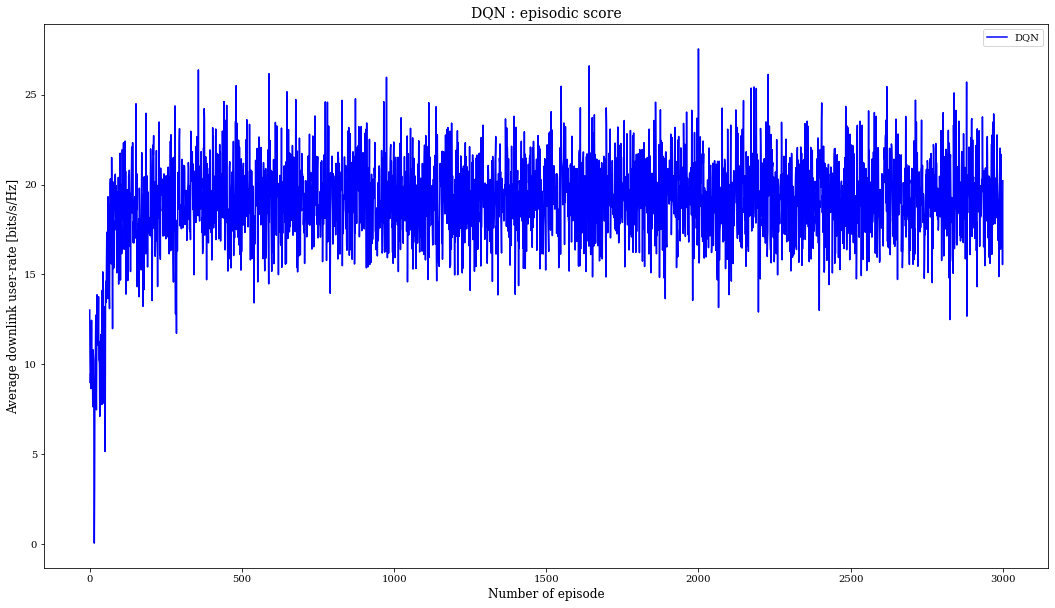

In [ ]:
EPISODES = 3000

env = M_MIMOEnv(N = 7, M = 32, K = 10)

if __name__ == "__main__":
  antenna, scores, DL_rates = [], [], []

  # GET STATE, ACTION SIZE OF CUSTOM ENV.
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  # CREATE DQN AGENT
  agent = DQNAgent(state_size, action_size, test_mode = False)
  scores, episodes, = [], []

  for e in range(EPISODES+1):
    done = False
    score  = 0
    state = env.reset()

    state = np.reshape(state, [1, state_size])

    # LEARNING <STATE, ACTION, REWARD, NEXT STATE> COLLECTED FOR EACH EPIOSDE
    while not done:
      action = agent.get_action(state)

      next_state, reward, done, info, downlink_rate = env.step(action)
      next_state = np.reshape(next_state, [1, state_size])

      agent.append_sample(state, action, reward, next_state, done)
      agent.train_model()

      # we use downlink user-rate as reward, but the values includes some panlty.
      score += reward
      state = next_state

      # PREDICT & UPDATE TARGET MODEL
      if done:
        agent.update_target_model()

        scores.append(score)
        episodes.append(e)
        # [SE] : equal 32.549863944255456, random 31.5269132670662, max 34.099149361187806, maxprob 37.888718763588415
        print('[{}] DQN Score {}'.format(e, score))

    if e % 50 == 0:
      print("================ save your model ================")
      agent.model.save_weights("./M_MIMO_DQN.h5")

  # PLOT THE SOCRE ACCORDING TO THE EPISODE
  plt.figure(figsize=(18,10))
  pylab.plot(episodes, scores, 'b')
  plt.xlabel('Number of episode', fontsize = 12)
  plt.ylabel('Average downlink user-rate [bits/s/Hz]', fontsize = 12)
  plt.title('DQN : episodic score', fontsize = 14)
  plt.legend(['DQN'])
  plt.savefig('DQN.png', dpi=300)

  # dataframe = pd.DataFrame({'Episode' : episodes, 'Score' : scores, 'downlink_rate' : DL_rates, 'transmit_power' : BS_powers, 'EE' : EEs})
  # dataframe.to_csv('train_DQN.csv', index = False, header=['Episode', 'Score', 'downlink_rate', 'transmit_power', 'EE'])

Reloading Agent form Memory
--

In [ ]:
# custom evaluation function without tensorflow and keras
def DRL_evaluate(env, agent):
  eval_reward = []
  for i in range(5):
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    episode_reward = 0
    while True:
      action = agent.get_action(state)
      next_state, reward, done, info, _ = env.step(action)
      episode_reward += reward
      if done:
        break
    eval_reward.append(episode_reward)
  return np.mean(eval_reward)

################################################################################
env = M_MIMOEnv(N = 7, M = 32, K = 10)
agent = DQNAgent(state_size, action_size, test_mode = True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

res = DRL_evaluate(env, agent)
print('acheivable objective function value {}'.format(res))